In [7]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)
np.set_printoptions(precision=2)

# Simple example

In [8]:
clusters = 3

n_cluster = [90, 50, 75]
n_total = sum(n_cluster)

means = [9, 21, 35]
std_devs = [2, 2, 2]

mix = np.random.normal(np.repeat(means, n_cluster), np.repeat(std_devs, n_cluster))

/home/osvaldo/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


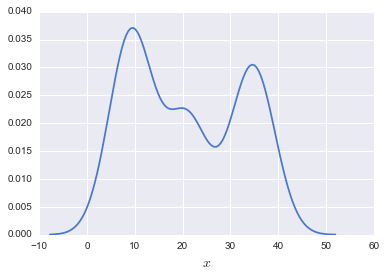

In [9]:
sns.kdeplot(np.array(mix))
plt.xlabel('$x$', fontsize=14)
plt.savefig('B04958_07_01.png', dpi=300, figsize=[5.5, 5.5])

In [10]:
# Author: Thomas Boggs

import matplotlib.tri as tri
from functools import reduce
from matplotlib import ticker, cm

_corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
_triangle = tri.Triangulation(_corners[:, 0], _corners[:, 1])
_midpoints = [(_corners[(i + 1) % 3] + _corners[(i + 2) % 3]) / 2.0 for i in range(3)]

def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.
    Arguments:
        xy: A length-2 sequence containing the x and y value.
    '''
    s = [(_corners[i] - _midpoints[i]).dot(xy - _midpoints[i]) / 0.75 for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

class Dirichlet(object):
    def __init__(self, alpha):
        '''Creates Dirichlet distribution with parameter `alpha`.'''
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) /reduce(mul, [gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])
    def sample(self, N):
        '''Generates a random sample of size `N`.'''
        return np.random.dirichlet(self._alpha, N)

def draw_pdf_contours(dist, nlevels=100, subdiv=8, **kwargs):
    '''Draws pdf contours over an equilateral triangle (2-simplex).
    Arguments:
        dist: A distribution instance with a `pdf` method.
        border (bool): If True, the simplex border is drawn.
        nlevels (int): Number of contours to draw.
        subdiv (int): Number of recursive mesh subdivisions to create.
        kwargs: Keyword args passed on to `plt.triplot`.
    '''
    refiner = tri.UniformTriRefiner(_triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, cmap=cm.Blues, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

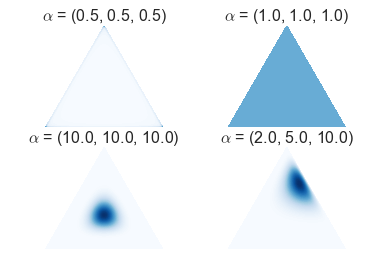

In [11]:
alphas = [[0.5] * 3, [1] * 3, [10] * 3, [2, 5, 10]]
for (i, alpha) in enumerate(alphas):
    plt.subplot(2, 2, i + 1)
    dist = Dirichlet(alpha)
    draw_pdf_contours(dist)
    plt.title(r'$\alpha$ = ({:.1f}, {:.1f}, {:.1f})'.format(*alpha), fontsize=16)
    
plt.savefig('B04958_07_02.png', dpi=300, figsize=[5.5, 5.5])

In [12]:
with pm.Model() as model_kg:
    # Each observation is assigned to a cluster/component with probability p
    p = pm.Dirichlet('p', a=np.ones(clusters))
    category = pm.Categorical('category', p=p, shape=n_total) 
    
    # Known Gaussians means
    means = pm.math.constant([10, 20, 35])

    y = pm.Normal('y', mu=means[category], sd=2, observed=mix)

    step1 = pm.ElemwiseCategorical(vars=[category], values=range(clusters))
    ## The CategoricalGibbsMetropolis is a recent addition to PyMC3
    ## I have not find the time yet to experiment with it.
    #step1 = pm.CategoricalGibbsMetropolis(vars=[category]) 
    step2 = pm.Metropolis(vars=[p])
    trace_kg = pm.sample(10000, step=[step1, step2])

/home/osvaldo/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
100%|██████████| 10000/10000 [01:08<00:00, 147.02it/s]


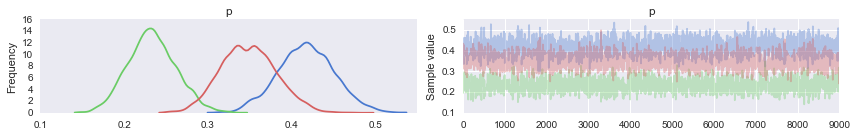

In [13]:
chain_kg = trace_kg[1000:]
varnames_kg = ['p']
pm.traceplot(chain_kg, varnames_kg)
plt.savefig('B04958_07_03.png', dpi=300, figsize=[5.5, 5.5])

In [14]:
pm.df_summary(chain_kg, varnames_kg)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
p__0,0.417704,0.033752,0.001013,0.346829,0.479218
p__1,0.233552,0.028791,0.000890,0.177837,0.288710
p__2,0.348745,0.032943,0.001060,0.289454,0.417193


In [15]:
#krusckeplot

In [16]:
with pm.Model() as model_ug:
    # Each observation is assigned to a cluster/component with probability p
    p = pm.Dirichlet('p', a=np.ones(clusters))
    category = pm.Categorical('category', p=p, shape=n_total) 
    
    # We estimate the unknown gaussians means and standard deviation
    means = pm.Normal('means', mu=[10, 20, 35], sd=2, shape=clusters)
    sd = pm.HalfCauchy('sd', 5)

    y = pm.Normal('y', mu=means[category], sd=sd, observed=mix)

    step1 = pm.ElemwiseCategorical(vars=[category], values=range(clusters))
    step2 = pm.Metropolis(vars=[means, sd, p])
    trace_ug = pm.sample(10000, step=[step1, step2])

/home/osvaldo/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
100%|██████████| 10000/10000 [01:08<00:00, 145.12it/s]


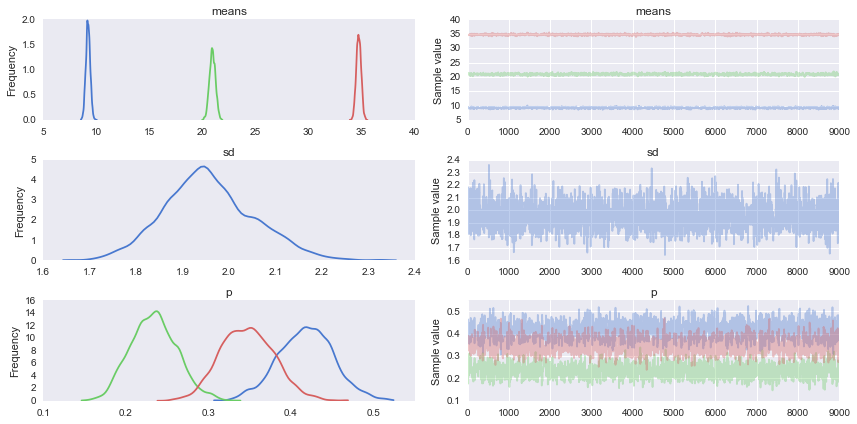

In [17]:
chain_ug = trace_ug[1000:]
varnames_ug = ['means', 'sd', 'p']
pm.traceplot(chain_ug, varnames_ug)
plt.savefig('B04958_07_05.png', dpi=300, figsize=[5.5, 5.5])

In [18]:
pm.df_summary(chain_ug, varnames_ug)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
means__0,9.236211,0.204840,0.006034,8.855020,9.650851
means__1,20.956618,0.283828,0.010723,20.428733,21.518236
means__2,34.729593,0.227088,0.007594,34.293947,35.166756
sd,1.957342,0.096721,0.002740,1.764754,2.143292
p__0,0.418383,0.033549,0.000843,0.345666,0.480083
p__1,0.234181,0.028187,0.000870,0.177693,0.286096
p__2,0.347436,0.032414,0.000942,0.286669,0.410189


In [19]:
ppc = pm.sample_ppc(chain_ug, 50, model_ug)

100%|██████████| 50/50 [00:01<00:00, 22.19it/s]


/home/osvaldo/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


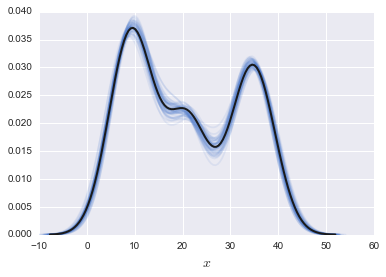

In [20]:
for i in ppc['y']:
    sns.kdeplot(i, alpha=0.1, color='b')

sns.kdeplot(np.array(mix), lw=2, color='k') # you may want to replace this with the posterior mean
plt.xlabel('$x$', fontsize=14)

plt.savefig('B04958_07_06.png', dpi=300, figsize=[5.5, 5.5])

## Marginalized Gaussian Mixture model

In [21]:
with pm.Model() as model_mg:
    p = pm.Dirichlet('p', a=np.ones(clusters))

    means = pm.Normal('means', mu=[10, 20, 35], sd=2, shape=clusters)
    sd = pm.HalfCauchy('sd', 5)
    
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=mix)
    
    step = pm.Metropolis()
    trace_mg = pm.sample(5000, step)

100%|██████████| 5000/5000 [00:05<00:00, 997.56it/s]


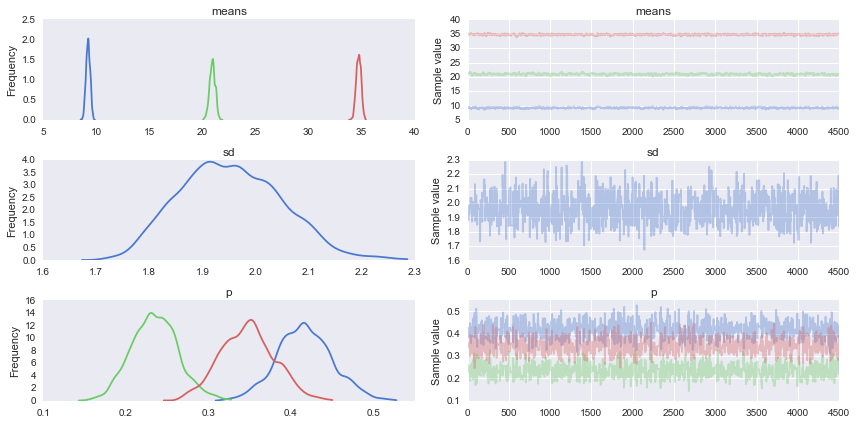

In [22]:
chain_mg = trace_mg[500:]
varnames_mg = ['means', 'sd', 'p']
pm.traceplot(chain_mg, varnames_mg);

## Zero inflated Poisson model

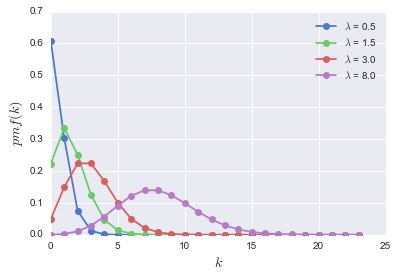

In [23]:
lam_params = [0.5, 1.5, 3, 8]
k = np.arange(0, max(lam_params) * 3)
for lam in lam_params:
    y = stats.poisson(lam).pmf(k)
    plt.plot(k, y, 'o-', label="$\\lambda$ = {:3.1f}".format(lam))
plt.legend()
plt.xlabel('$k$', fontsize=14)
plt.ylabel('$pmf(k)$', fontsize=14)
plt.savefig('B04958_07_07.png', dpi=300, figsize=(5.5, 5.5))

In [24]:
np.random.seed(42)
n = 100
theta = 2.5  # Poisson rate
pi = 0.1  # probability of extra-zeros (pi = 1-psi)

# Simulate some data
counts = np.array([(np.random.random() > pi) * np.random.poisson(theta) for i in range(n)])

In [25]:
#plt.hist(counts, bins=30);

In [27]:
with pm.Model() as ZIP:
    psi = pm.Beta('psi', 1, 1)
    lam = pm.Gamma('lam', 2, 0.1)
    
    y = pm.ZeroInflatedPoisson('y', lam, psi, observed=counts)
    trace_ZIP = pm.sample(5000)

100%|██████████| 5000/5000 [00:05<00:00, 937.85it/s]


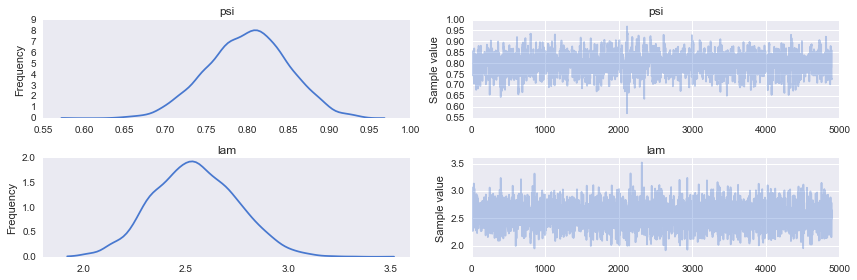

In [28]:
chain_ZIP = trace_ZIP[100:]
pm.traceplot(chain_ZIP);
plt.savefig('B04958_07_08.png', dpi=300, figsize=(5.5, 5.5))

In [29]:
pm.df_summary(chain_ZIP)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
psi,0.800781,0.049409,0.001337,0.708644,0.897532
lam,2.546409,0.204578,0.003423,2.135169,2.928418


## Zero inflated Poisson regression

In [30]:
#Kruschke plot

In [31]:
fish_data = pd.read_csv('fish.csv')
fish_data.head()

,nofish,livebait,camper,persons,child,xb,zg,count
0,1,0,0,1,0,-0.896315,3.050405,0
1,0,1,1,1,0,-0.558345,1.746149,0
2,0,1,0,1,0,-0.401731,0.279939,0
3,0,1,1,2,1,-0.956298,-0.601526,0
4,0,1,0,1,0,0.436891,0.527709,1


In [32]:
#plt.hist(fish_data['count'], bins=20);

In [33]:
with pm.Model() as ZIP_reg:
    psi = pm.Beta('psi', 1, 1)
    
    alpha = pm.Normal('alpha', 0, 10)
    beta = pm.Normal('beta', 0, 10, shape=2)
    lam = pm.math.exp(alpha + beta[0] * fish_data['child'] + beta[1] * fish_data['camper'])
    
    y = pm.ZeroInflatedPoisson('y', lam, psi, observed=fish_data['count'])
    trace_ZIP_reg = pm.sample(2000)

100%|██████████| 2000/2000 [00:06<00:00, 301.31it/s]


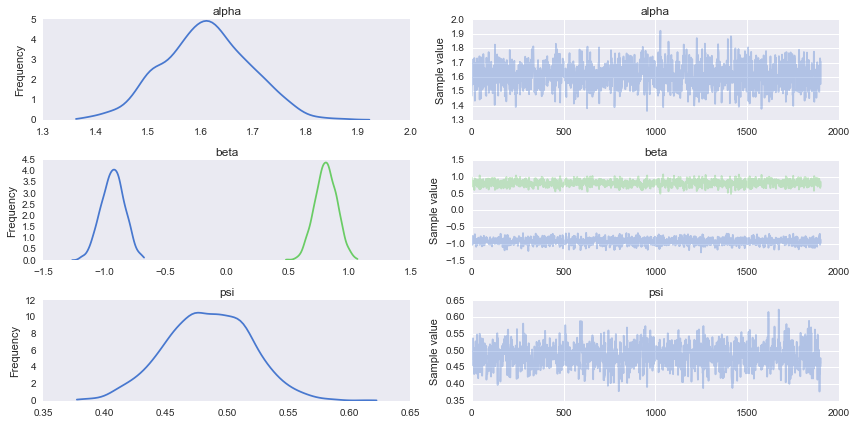

In [34]:
chain_ZIP_reg = trace_ZIP_reg[100:]
pm.traceplot(chain_ZIP_reg);
plt.savefig('B04958_07_10.png', dpi=300, figsize=(5.5, 5.5))

In [35]:
pm.df_summary(chain_ZIP_reg)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,1.610778,0.083275,0.002258,1.459838,1.774502
beta__0,-0.930333,0.095332,0.002434,-1.124849,-0.757806
beta__1,0.808623,0.089715,0.002457,0.628221,0.974075
psi,0.484984,0.034880,0.001142,0.414199,0.549104


In [36]:
children =  [0, 1, 2, 3, 4]
fish_count_pred_0 = []
fish_count_pred_1 = []
thin = 5
for n in children:
    without_camper = chain_ZIP_reg['alpha'][::thin] + chain_ZIP_reg['beta'][:,0][::thin] * n
    with_camper = without_camper + chain_ZIP_reg['beta'][:,1][::thin]
    fish_count_pred_0.append(np.exp(without_camper))
    fish_count_pred_1.append(np.exp(with_camper))

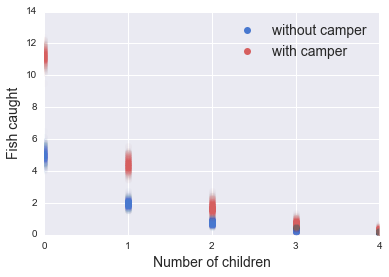

In [37]:
plt.plot(children, fish_count_pred_0, 'bo', alpha=0.01)
plt.plot(children, fish_count_pred_1, 'ro', alpha=0.01)

plt.xticks(children);
plt.xlabel('Number of children', fontsize=14)
plt.ylabel('Fish caught', fontsize=14)
plt.plot([], 'bo', label='without camper')
plt.plot([], 'ro', label='with camper')
plt.legend(fontsize=14)
plt.savefig('B04958_07_11.png', dpi=300, figsize=(5.5, 5.5))

## Robust logistic Regression

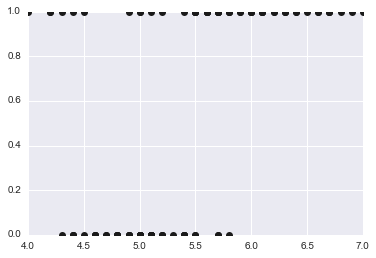

In [38]:
iris = sns.load_dataset("iris")
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values
y_0 = np.concatenate((y_0, np.ones(6)))
x_0 = np.concatenate((x_0, [4.2, 4.5, 4.0, 4.3, 4.2, 4.4]))
x_0_m = x_0 - x_0.mean()
plt.plot(x_0, y_0, 'o', color='k')
plt.savefig('B04958_07_12.png', dpi=300, figsize=(5.5, 5.5))

In [39]:
with pm.Model() as model_rlg:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    
    mu = alpha_tmp + beta * x_0_m
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    pi = pm.Beta('pi', 1, 1)
    p = pi * 0.5 + (1 - pi) * theta
    
    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_0.mean())
    bd = pm.Deterministic('bd', -alpha/beta)
    
    yl = pm.Bernoulli('yl', p=p, observed=y_0)

    trace_rlg = pm.sample(2000, start=pm.find_MAP())

100%|██████████| 2000/2000 [00:12<00:00, 154.29it/s]


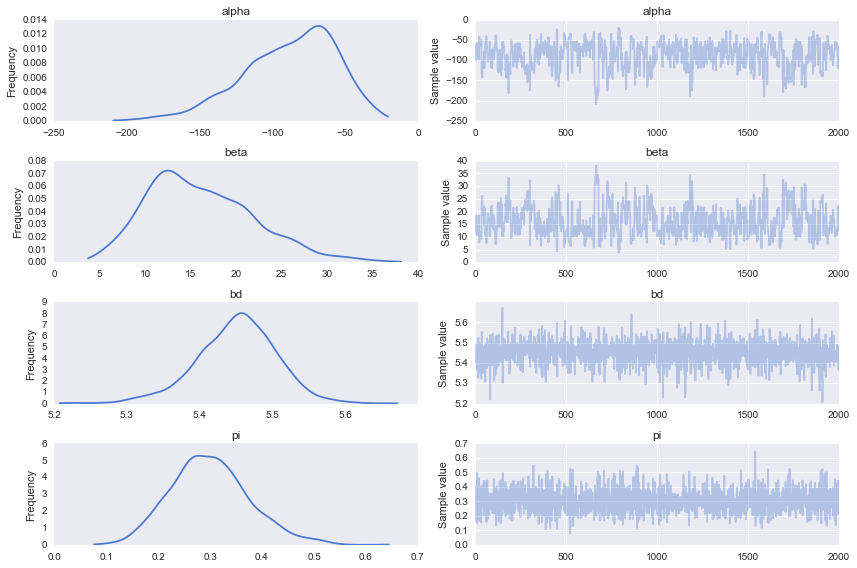

In [40]:
varnames = ['alpha', 'beta', 'bd', 'pi']
pm.traceplot(trace_rlg, varnames)
plt.savefig('B04958_07_13.png', dpi=300, figsize=(5.5, 5.5))

In [41]:
pm.df_summary(trace_rlg, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-88.045398,32.057573,1.990573,-151.353483,-32.683495
beta,16.148924,5.867278,0.363771,6.209711,27.952638
bd,5.450774,0.054827,0.001557,5.338378,5.555840
pi,0.300405,0.075640,0.001696,0.154393,0.447944


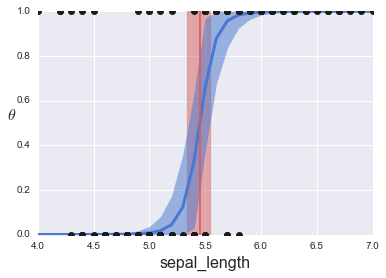

In [42]:
theta = trace_rlg['theta'].mean(axis=0)
idx = np.argsort(x_0)
plt.plot(x_0[idx], theta[idx], color='b', lw=3);
plt.axvline(trace_rlg['bd'].mean(), ymax=1, color='r')
bd_hpd = pm.hpd(trace_rlg['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)

plt.plot(x_0, y_0, 'o', color='k')
theta_hpd = pm.hpd(trace_rlg['theta'])[idx]
plt.fill_between(x_0[idx], theta_hpd[:,0], theta_hpd[:,1], color='b', alpha=0.5)

plt.xlabel(x_n, fontsize=16)
plt.ylabel('$\\theta$', rotation=0, fontsize=16)
plt.savefig('B04958_07_14.png', dpi=300, figsize=(5.5, 5.5))

In [43]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was created on a %s computer running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\nPandas %s" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__, pd.__version__))

This notebook was created on a x86_64 computer running debian stretch/sid and using:
Python 3.5.2
IPython 5.0.0
PyMC3 3.0.rc2
NumPy 1.11.2
SciPy 0.18.1
Matplotlib 1.5.3
Seaborn 0.7.1
Pandas 0.19.0
